# Goal expectation model

In this notebook i'll train a logistic regression model for estimate the goal expectation of a shot. That is, whit a given shot, the probabily that it ends in a goal 

First, some imports and settings. I'll use statsbomb's open data, you can download it from here: https://github.com/statsbomb/statsbombpy.
For field plotting, I use matplotsoccer, you can get it from here: https://github.com/TomDecroos/matplotsoccer

In [1]:
from statsbombpy import sb
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotsoccer
import math
matplotsoccer.spadl_config['length'] = 120
matplotsoccer.spadl_config['width'] = 80
matplotsoccer.zline = -4900

Here I declare methos needed for angle and distance calculations.

In [74]:
def calculate_angle(vertex, to1, to2):
    x1, y1 = vertex
    x2, y2 = to1
    x3, y3 = to2
    
    p12 = math.sqrt((x1 - x2)**2 + (y1-y2)**2)
    p13 = math.sqrt((x1 - x3)**2 + (y1-y3)**2)
    p23 = math.sqrt((x2 - x3)**2 + (y2-y3)**2)
    term = (p12**2+p13**2-p23**2) / (2*p12*p13)
    return round(math.degrees(np.arccos(term)),2)

def distance_points(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    return round(math.sqrt((x1 - x2)**2 + (y1 - y2)**2), 2)
    
def shot_angle(shoter):
    return calculate_angle(shoter, (120,36), (120,44)), distance_points(shoter, (120, 40)) 

def keeper_angle(shoter, keeper):
    return calculate_angle(shoter, (120,44), keeper), distance_points(shoter, keeper)

def calculate_keeper_scope(distance):
    return distance * 0.15

def is_blocking(shoter, shot_angle, player, use_delta=True):
    x,y = player
    a = calculate_angle(shoter, (120,44), (x, y))
    a2 = calculate_angle(shoter, (x, y), (120,36))

    if use_delta:
        d =  distance_points(shoter, player)
        delta = max(1.3, 2 - (d ** 1/6))
        return a < shot_angle * delta and a2 < shot_angle * delta
    else:
        return a < shot_angle and a2 < shot_angle
        
def plot_shot(event, title=''):
    shoter = event['location'] 
    shot = event['shot']
    
    x = []
    y = []
    c = []
    gp_x = 0
    gp_y = 0
    try:
        for p in shot['freeze_frame']:
            if p['position']['name'] == 'Goalkeeper':
                gp_x = p['location'][0]
                gp_y = p['location'][1]
            else:
                x.append(p['location'][0])
                y.append(p['location'][1])
                if p['teammate']:
                    c.append('gray')
                else:
                    c.append('blue')
    except KeyError:
        gp_x, gp_y = 120, 40
    plt = matplotsoccer.field("green",figsize=6, show=False)
    plt.scatter(x,y, c=c)
    s_angle, _ = shot_angle(shoter)
    block_players_count = 0
    blockers = []
    for j in range(len(x)):
        if is_blocking(shoter, s_angle, (x[j], y[j])):
            blockers.append((x[j], y[j]))
            block_players_count +=1
    if block_players_count > 0:
        plt.scatter(*zip(*blockers), c='orange')
        
    plt.set_title(f"{i} - Players blocking {block_players_count} - {title}")
    plt.scatter(shoter[0],shoter[1], c='red')
    plt.plot([shoter[0],120],[shoter[1],36], c='red', zorder=9000)
    plt.plot([shoter[0],120],[shoter[1],44], c='red',zorder=9000)
    plt.text((shoter[0]+120)/2,(shoter[1]+44)/2, shot_angle(shoter),zorder=9000)
    plt.scatter(gp_x,gp_y, c='yellow')
    
    
    a, d = keeper_angle(shoter, (gp_x,gp_y))
    plt.text(gp_x,gp_y, (a,d),zorder=9000)
    scope = calculate_keeper_scope(d)
    plt.plot([gp_x,gp_x],[int(gp_y+scope),int(gp_y-scope)], c='yellow',zorder=9000)
    
    fig = plt.figure
    fig.patch.set_facecolor('xkcd:white')
    plt.axis("on")
    plt.set_xlim(70, 120)
    plt.set_ylim(16, 64)
    

Now, I plot sample of shots, and look if the lines and calculated angles are ok.

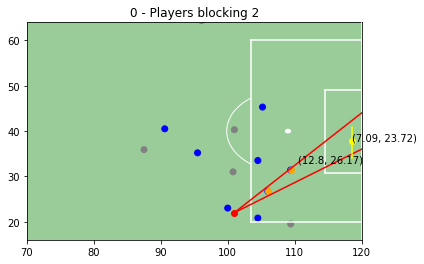

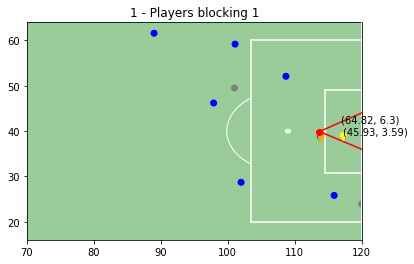

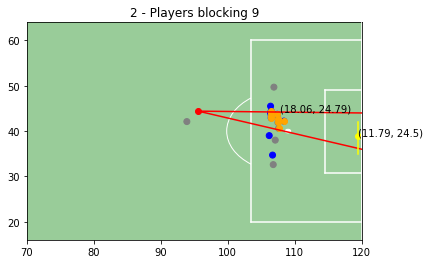

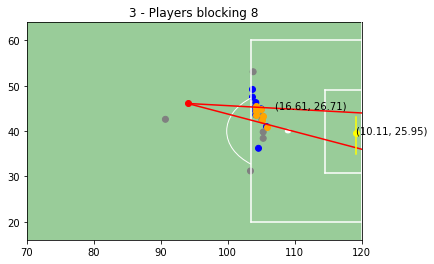

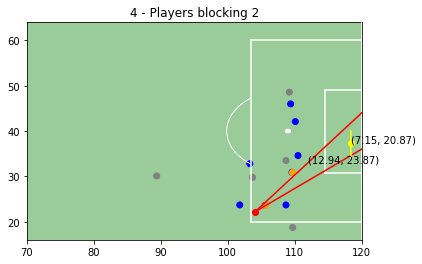

In [70]:
for i in range(5):
    plot_shot(events['shots'].iloc[i])

## Getting and preprocess the data

The next function converts a shot event to an array with the features i'll use for the model

In [13]:
def shot_to_row(event):
    shoter = event['location'] 
    shot = event['shot']
    players = []
    teammates = []
    keeper = (0, 0)
    is_penalty = False
    try:
        for p in shot['freeze_frame']:
            if p['position']['name'] == 'Goalkeeper':
                keeper = (p['location'][0], p['location'][1])
            else:
                if not p['teammate']:
                    players.append((p['location'][0], p['location'][1]))
                else:
                    teammates.append((p['location'][0], p['location'][1]))
    except KeyError:
        is_penalty = True
        keeper = (120, 40)
    s_angle, s_distance = shot_angle(shoter)
    blocking_distances = [distance_points(shoter, p) for p in players if is_blocking(shoter, s_angle, p)]
            
    teammates_distances = [distance_points(shoter, p) for p in teammates if is_blocking(shoter, s_angle, p, use_delta=False)]
            
    k_angle, k_distance = keeper_angle(shoter, keeper)
    k_scope = calculate_keeper_scope(k_distance)
    d=dict()
    d['shot_angle'] = s_angle
    d['shot_distance'] = s_distance
    d['keeper_angle'] = k_angle
    d['keeper_scope'] = k_scope
    d['keeper_scope_angle'] = calculate_angle(shoter, (keeper[0], keeper[1]+k_scope), (keeper[0], keeper[1]-k_scope))
    d['keeper_distance'] = k_distance
    
    d['is_penalty'] = event['shot']['type']['name'] == 'Penalty'
    d['is_freekick'] = event['shot']['type']['name'] == 'Free Kick' or event['shot']['type']['name'] == 'Corner'
#     d['is_corner'] = event['shot']['type']['name'] == 'Corner'
    d['is_openplay'] = event['shot']['type']['name'] == 'Open Play'
    
    if not is_penalty:
        d['blocking_players_count'] = len(blocking_distances)
        if d['blocking_players_count'] > 0: 
            d['nearest_player_distance'] = np.min(blocking_distances)
            d['blocking_player_mean_distance'] = np.mean(blocking_distances)
        else:
            d['nearest_player_distance'] = -1
            d['blocking_player_mean_distance'] = -1
    
        d['teammates_count'] = len(teammates_distances)
    else:
        d['blocking_players_count'] = 0
        d['nearest_player_distance'] = -1
        d['blocking_player_mean_distance'] = -1
        d['nearest_player_distance'] = -1
        d['blocking_player_mean_distance'] = -1
        d['teammates_count'] = 0
        
    d['keep_angle_by_shot_angle'] = k_angle / s_angle
    d['scope_angle_by_shot_angle'] = d['keeper_scope_angle'] / s_angle
    d['body_part'] = event['shot']['body_part']['name']
    d['is_goal'] = event['shot']['outcome']['name'] == 'Goal'
    
    return d

columns = [
            'shot_angle',
            'shot_distance',
            'keeper_angle',
            'keeper_scope',
            'keeper_scope_angle',
            'keeper_distance',
            'is_penalty',  
            'is_freekick',
#             'is_corner',
            'is_openplay',
            'nearest_player_distance',
            'blocking_players_count',
            'blocking_player_mean_distance',
            'teammates_count',
            'keep_angle_by_shot_angle',
            'scope_angle_by_shot_angle',
            'body_part',
            'season',
            'is_goal',
            ]

Now, i will get all male competitions shots, and convert it to a numpy matrix of data

In [14]:
data = []

def add_rows(country, division, season, gender, data):
    comp_events = sb.competition_events(
                        country=country,
                        division=division ,
                        season=season,
                        gender=gender,
                        split=True
                    )
    print(f"Shot count {comp_events['shots'].shape}")
    errores = 0
    for i in range(comp_events['shots'].shape[0]):
        try:
            result_dict = shot_to_row(comp_events['shots'].iloc[i])
            result_dict['season'] = season
            data.append([result_dict[c] for c in columns])
        except (KeyError,ZeroDivisionError):
            errores +=1
    print(f"Errores {errores}")

male_competitions = competitions[(competitions.competition_gender == 'male') & (competitions.season_name != '1999/2000')]
print(male_competitions.shape)
for i,comp in male_competitions.iterrows():
    add_rows(comp.country_name, comp.competition_name, comp.season_name, "male", data)

data_arr = np.asarray(data)
print(data_arr.shape)

(32, 8)
credentials were not supplied. open data access only
credentials were not supplied. open data access only
Shot count (30, 20)
Errores 0
credentials were not supplied. open data access only
credentials were not supplied. open data access only
Shot count (28, 19)
Errores 0
credentials were not supplied. open data access only
credentials were not supplied. open data access only
Shot count (27, 18)
Errores 0
credentials were not supplied. open data access only
credentials were not supplied. open data access only
Shot count (53, 19)
Errores 0
credentials were not supplied. open data access only
credentials were not supplied. open data access only


C:\Users\aferraresso\anaconda3\envs\futbol\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in arccos
  app.launch_new_instance()


Shot count (32, 19)
Errores 0
credentials were not supplied. open data access only
credentials were not supplied. open data access only
Shot count (32, 19)
Errores 0
credentials were not supplied. open data access only
credentials were not supplied. open data access only
Shot count (30, 19)
Errores 0
credentials were not supplied. open data access only
credentials were not supplied. open data access only
Shot count (59, 19)
Errores 0
credentials were not supplied. open data access only
credentials were not supplied. open data access only
Shot count (26, 19)
Errores 0
credentials were not supplied. open data access only
credentials were not supplied. open data access only
Shot count (34, 19)
Errores 0
credentials were not supplied. open data access only
credentials were not supplied. open data access only
Shot count (23, 19)
Errores 0
credentials were not supplied. open data access only
credentials were not supplied. open data access only
Shot count (20, 19)
Errores 0
credentials were n

After that, i save it as pandas DataFrame, for save time in future uses

In [15]:
import pandas as pd
df = pd.DataFrame(data_arr, columns=columns)

print(df.shape)
df.is_goal = df.is_goal == 'True'
df.is_penalty = df.is_penalty == 'True'
df.to_csv('shots_male_comps.csv', index=False)
df.head()

(14952, 18)


,shot_angle,shot_distance,keeper_angle,keeper_scope,keeper_scope_angle,keeper_distance,is_penalty,is_freekick,is_openplay,nearest_player_distance,blocking_players_count,blocking_player_mean_distance,teammates_count,keep_angle_by_shot_angle,scope_angle_by_shot_angle,body_part,season,is_goal
0,37.45,11.8,18.77,1.77,17.06,11.8,True,False,False,-1,0,-1,0,0.5012016021361815,0.4555407209612816,Left Foot,2018/2019,True
1,16.01,28.27,8.99,3.9765,16.94,26.51,False,False,True,4.3,2,9.54,0,0.561524047470331,1.0580886945658963,Right Foot,2018/2019,False
2,10.84,35.5,3.08,5.001,14.85,33.34,False,False,True,-1,0,-1,0,0.2841328413284133,1.3699261992619927,Right Foot,2018/2019,False
3,16.95,25.82,8.31,3.723,16.46,24.82,False,False,True,5.22,1,5.22,0,0.4902654867256638,0.9710914454277287,Left Foot,2018/2019,False
4,7.72,20.72,2.93,2.5934999999999997,6.38,17.29,False,False,True,-1,0,-1,0,0.3795336787564767,0.8264248704663213,Left Foot,2018/2019,False


There are almost 15 thousand shots, it isn't a great number, but it's enough for my prototype. The next cell reads the pandas DataFrame from the csv file, uncomment it if you need it

In [ ]:
# import pandas as pd
# import numpy as np
# data = pd.read_csv('shots_male_comps.csv')


The next step is to prepare the data for our model. I would encode the body_part as Foot or Other, for simplicity

In [16]:
both_foot=False
if not both_foot:
    msk = data['body_part'].isin(['Right Foot', 'Left Foot'])
    data.loc[msk, 'body_part'] = ['Foot']
    msk = data['body_part'].isin(['Head', 'Other'])
    data.loc[msk, 'body_part'] = ['Other']

# from sklearn.preprocessing import LabelEncoder
# le_body_part_ = LabelEncoder()
# data[['body_part']] = le_body_part_.fit_transform(data[['body_part']])

data.is_goal = data.is_goal.astype(int)
data.is_penalty = data.is_penalty.astype(int)
#NaN son algunos angulos que resultaron incalculables, por ahora pongo -1
data.fillna(-1, inplace=True)
data['body_part'] = (data['body_part'] == 'Foot').astype(int)
# data = pd.get_dummies(data, columns=['type','body_part'])
data.head()

Body parts ['Left Foot' 'Right Foot' 'Head' 'Other']
Body parts ['Foot' 'Other']


,shot_angle,shot_distance,keeper_angle,keeper_scope,keeper_scope_angle,keeper_distance,is_penalty,is_freekick,is_openplay,nearest_player_distance,blocking_players_count,blocking_player_mean_distance,teammates_count,keep_angle_by_shot_angle,scope_angle_by_shot_angle,body_part,season,is_goal
0,37.45,11.80,18.77,1.7700,17.06,11.80,1,False,False,-1.00,0,-1.00,0,0.501202,0.455541,1,2018/2019,1
1,16.01,28.27,8.99,3.9765,16.94,26.51,0,False,True,4.30,2,9.54,0,0.561524,1.058089,1,2018/2019,0
2,10.84,35.50,3.08,5.0010,14.85,33.34,0,False,True,-1.00,0,-1.00,0,0.284133,1.369926,1,2018/2019,0
3,16.95,25.82,8.31,3.7230,16.46,24.82,0,False,True,5.22,1,5.22,0,0.490265,0.971091,1,2018/2019,0
4,7.72,20.72,2.93,2.5935,6.38,17.29,0,False,True,-1.00,0,-1.00,0,0.379534,0.826425,1,2018/2019,0


With the next plot we look the distribution of goals with ours features and aome combinations of them

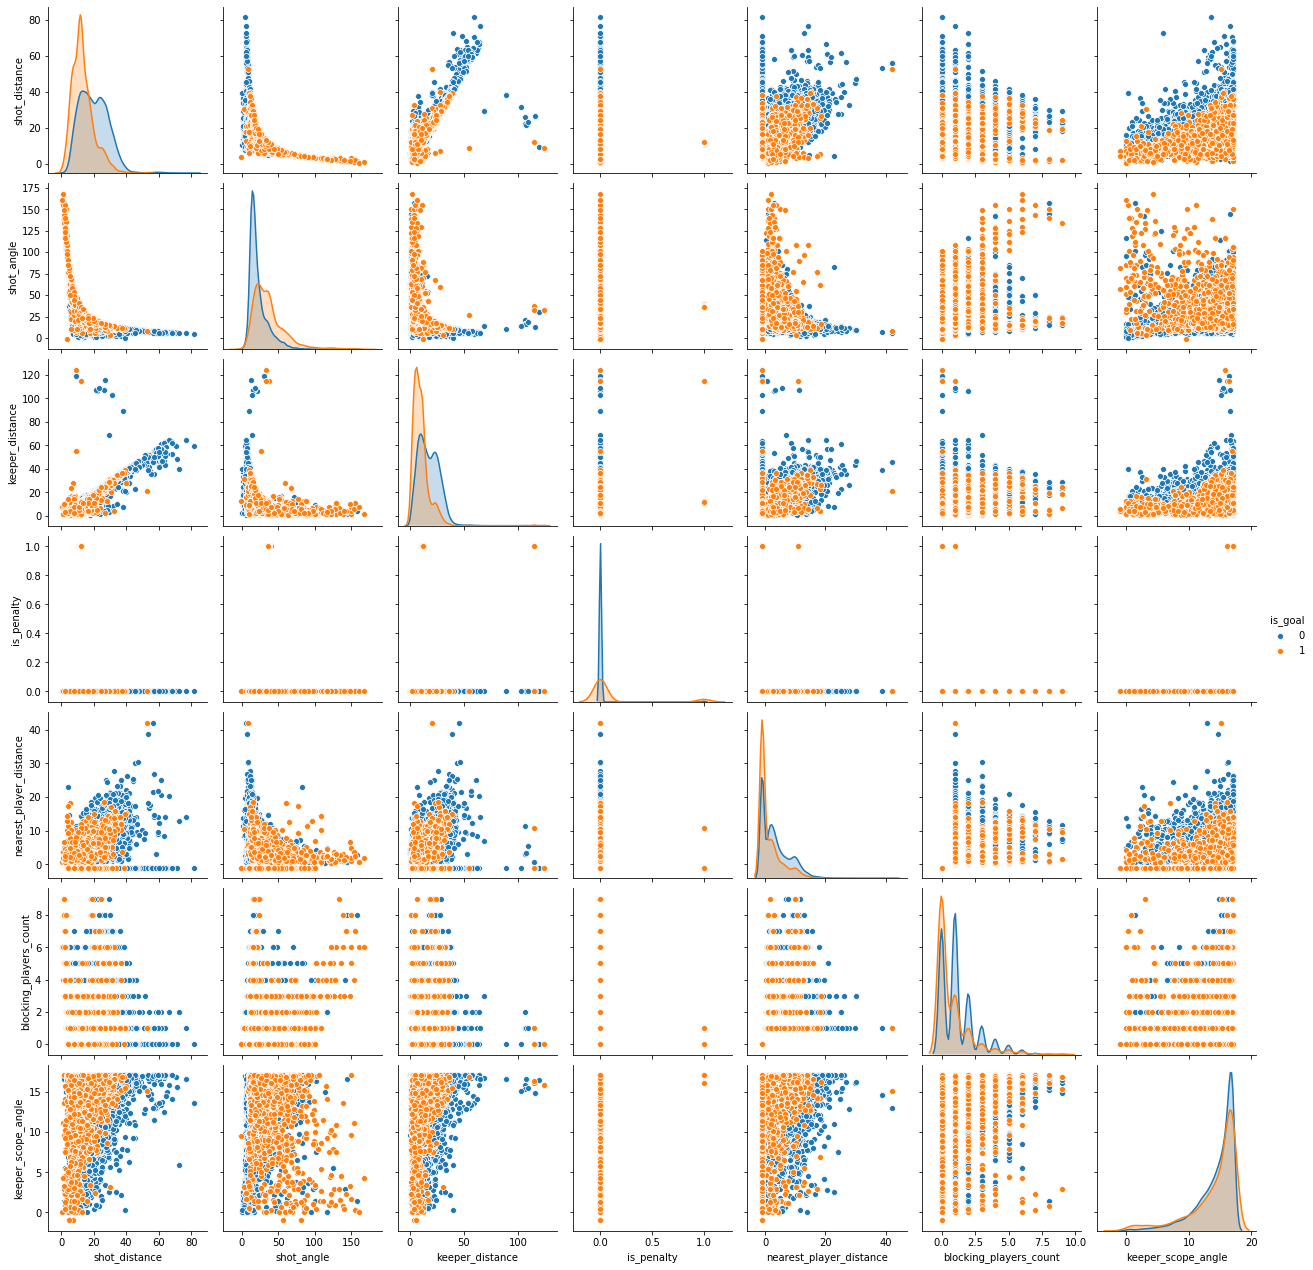

In [67]:
import seaborn as sns

g = sns.pairplot(data, vars=['shot_distance', 'shot_angle', 'keeper_distance', 
                             'is_penalty', 'nearest_player_distance','blocking_players_count',
                            'keeper_scope_angle'], hue='is_goal')

As any one can supose, the shorter shot discance can improve goal probabilities. In contrast, when increase the number of blocking players, reduce the goal probability. Other importante feature is the angle, we can see that with small angles the probabity of make a goal reduces drastically.

We will separe 15% of data for testing the model

In [72]:
train_data=data.sample(frac=0.85) 
test_data=data.drop(train_data.index)

print('Train shape', train_data.shape)
print('Test shape', test_data.shape)

Train shape (12709, 18)
Test shape (2243, 18)


Next, we prepare data for training and testing

In [35]:
valid_cols = [c for c in data.columns if c not in ['is_goal', 'season','keeper_scope'
                                                   ]] #

X_train, y_train = train_data[valid_cols].astype(float), train_data['is_goal']
X_val,  y_val = test_data[valid_cols].astype(float), test_data['is_goal'] 

print(X_train.shape, y_train.shape)

(12709, 15) (12709,)


Now, we train the Logistic Regression model. I choose this type of model for two reasons:
- This model is fast, this is usefull if a need to calculate xG of many events of a match, not only shots.
- Logistic regression returns well calibrated predictions by default as it directly optimizes log-loss. (https://scikit-learn.org/stable/modules/calibration.html)

[<matplotlib.lines.Line2D at 0x2288c49fe48>]

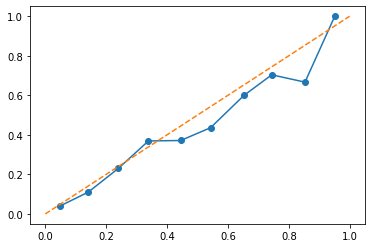

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

def fit_logistic(X_fit, y_fit, X_val, y_val):
    clf = LogisticRegression(random_state=0,
                             penalty='none',
                             solver='lbfgs',
                             max_iter=10000,
                            ).fit(X_fit, y_fit)
    r = clf.predict_proba(X_val)
    
    return clf, r


model,lr_result = fit_logistic(X_train, y_train, X_val, y_val)

#This plots shows how well calibrated is the model
prob_pred, prob_true = calibration_curve(y_val, lr_result[:,1], n_bins=10, normalize=True)
plt.plot(prob_true, prob_pred, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--')



The calibration curve shows a quite well calibration, mostly with lower probabilities. 

The next two plots show how our model considers the features 

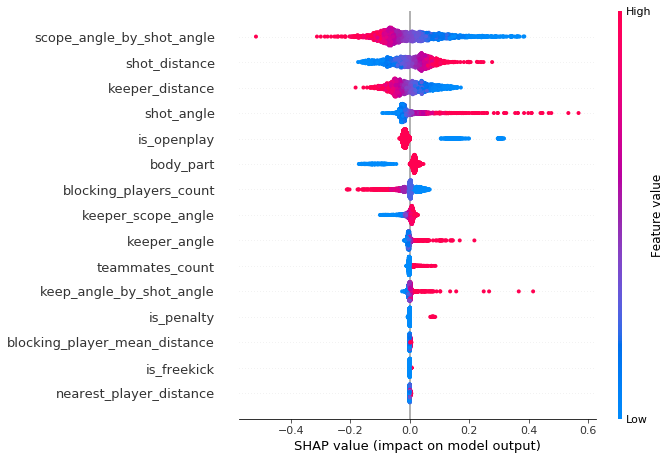

In [73]:
import shap
import matplotlib.pyplot as plt



lr_explainer = shap.SamplingExplainer(model=model.predict_proba, data=X_train)

shap_values = lr_explainer.shap_values(X=X_val, n_samples=100, l1_reg=False)

shap.summary_plot(shap_values[1], X_val, valid_cols)


In [55]:
import eli5
eli5.show_weights(model, feature_names=valid_cols)

Weight?,Feature
+1.324,body_part
+0.465,is_penalty
+0.230,keep_angle_by_shot_angle
+0.208,teammates_count
+0.080,shot_distance
+0.044,is_freekick
+0.043,keeper_scope_angle
+0.026,shot_angle
+0.008,keeper_angle
+0.002,blocking_player_mean_distance


In [56]:
plot_events = sb.competition_events(
    country="Spain",
    division= "La Liga",
    season='2018/2019',
    gender="male",
    split=True
)
print(plot_events['shots'].shape)

credentials were not supplied. open data access only
credentials were not supplied. open data access only
(885, 20)


Ok, now we will see how our model works. We will plot some random shots, with the corresponding probability and if it was a goal.

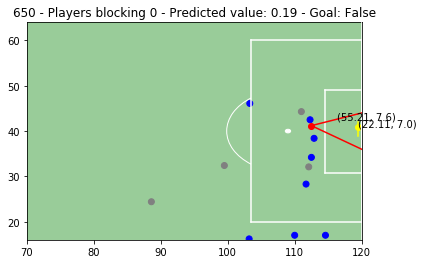

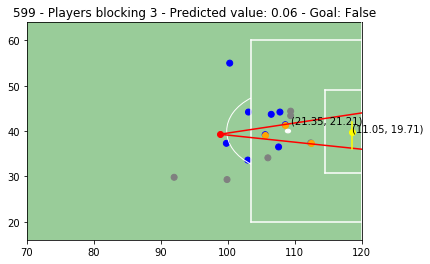

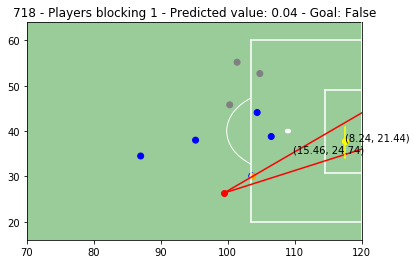

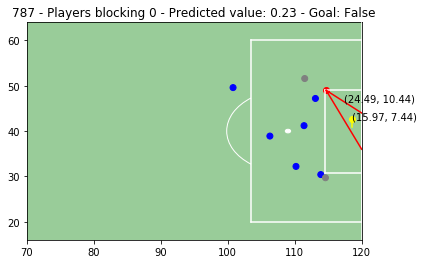

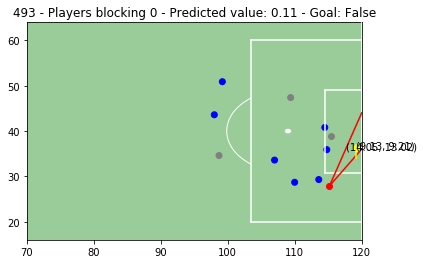

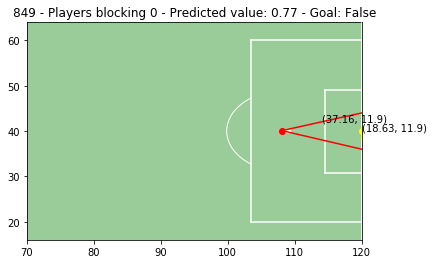

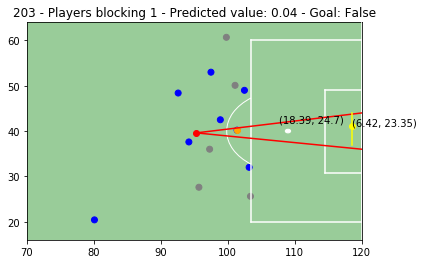

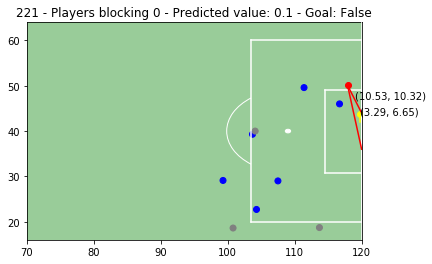

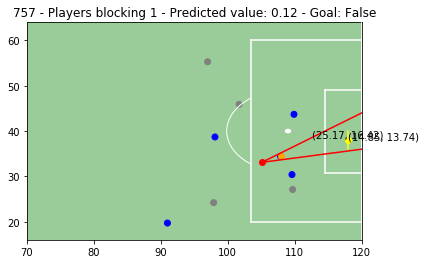

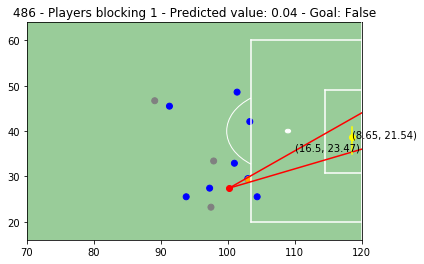

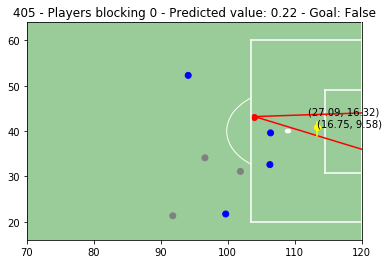

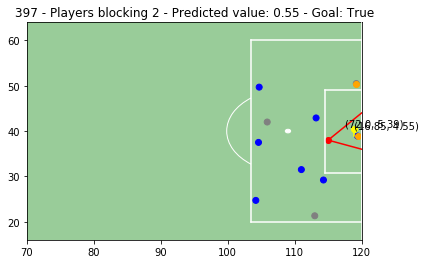

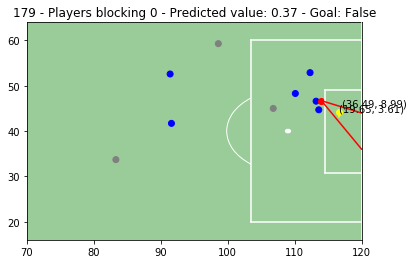

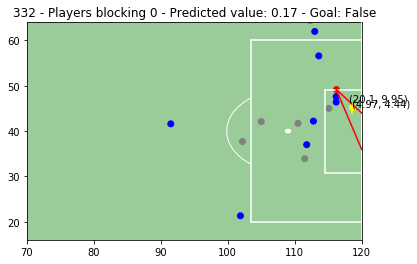

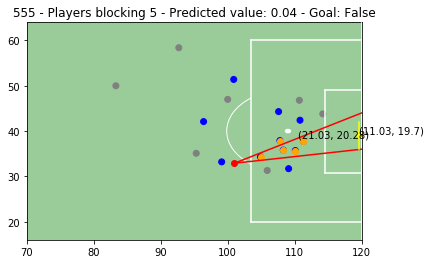

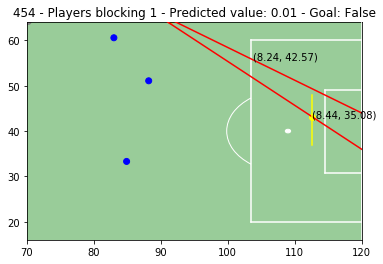

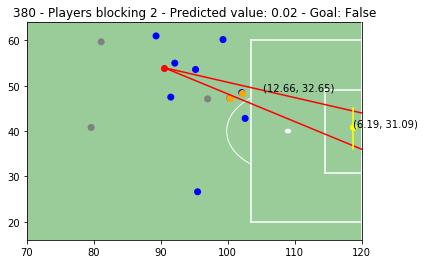

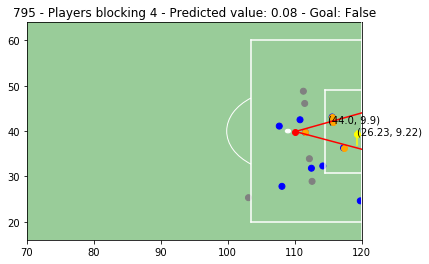

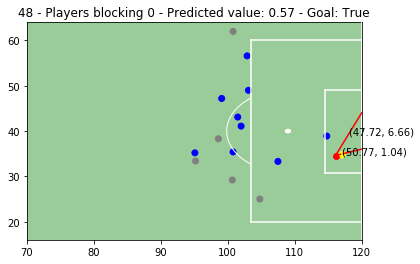

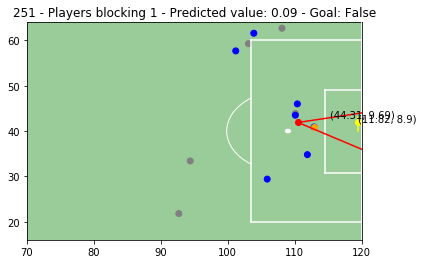

In [75]:
analyze_index = np.random.choice(plot_events['shots'].shape[0], 20, replace=False)
from IPython.display import display

for i in analyze_index:
    result_dict = shot_to_row(plot_events['shots'].iloc[i])
    result_dict['season'] = '2018/2019'
    sample = np.asarray([[result_dict[c] for c in columns]])
    df = pd.DataFrame(sample, columns=columns)
    
    df[['body_part']] = df['body_part'].isin(['Right Foot', 'Left Foot']).astype(int)
    for c in [c for c in valid_cols if 'is_' in c]:
        df[c] = df[c] == 'True'
    
    df[valid_cols] = df[valid_cols].astype(float)
    prob = model.predict_proba(df[valid_cols])[0,1]
    plot_shot(plot_events['shots'].iloc[i], title=f"Predicted value: {round(prob,2)} - Goal: {result_dict['is_goal']}")
    plt.show()
    display(eli5.show_prediction(model, df[valid_cols], targets=[1], 
                                 feature_names=valid_cols, show_feature_values=True))

Ok, the model works very well, we can see that predict very accurate probalities. 